In [1]:
import skimage.io as io
import numpy as np
import csv
import datetime
import glob
import ipywidgets as widgets
from PIL import Image as im
import os
from matplotlib import pyplot as plt
import skimage.morphology as skmorph
import scipy.ndimage as ndi
from skimage import data
from skimage import filters
from skimage import feature
from skimage.color import rgb2gray, gray2rgb
import skimage.measure as skmeas
import skimage.segmentation as skseg
from skimage.feature import peak_local_max
from skimage.util import img_as_ubyte
from skimage.draw import disk, circle_perimeter
from scipy.spatial import cKDTree
import skimage.transform as tf
import pandas as pd
import cv2


# global variables
if os.name == "nt":
    FILE_SEP = "\\"
else:
    FILE_SEP = "/"

In [2]:
#Selecting Image Stack Files *From John's Notebook*
%matplotlib widget

# global variables
image_files = {}    # image stack name(s)
image_fps = 10


# create image file(s) widget
image_files = sorted([f.split(FILE_SEP)[-1] for f in glob.glob("../image_stacks/*.tif", recursive=False)], key=str.casefold)
image_widget = widgets.SelectMultiple(options=image_files, description='Image stack(s)', 
                            disabled=False, layout={'width':'400px'}, style={'description_width':'150px'})

# display and respond to the widgets
def f(w1):
  global image_files
  image_files = image_widget.value
display(widgets.interactive(f, w1=image_widget))

interactive(children=(SelectMultiple(description='Image stack(s)', layout=Layout(width='400px'), options=('mg0…

In [3]:
### Image stack labels *From John's Notebook*
%matplotlib widget

# global variables
image_tags = []         # list of image file tag labels
roi_idx = 0             # image file index to use to use for generating roi's

# create image tag widget(s)
image_tag_widgets = []
m = 6                   # a static number of widgets to display
n = len(image_files)    # the number of image stack files selected
for i in range(m):
  if i >= n:
    d = ' '
  else:
    d = image_files[i]
  image_tag_widgets.append(widgets.Text(value='', placeholder='enter a label', description=d,
                    disabled=(i>=n), layout={'width':'300px'}, style={'description_width':'200px'}))
# display and respond to the widgets
def f(w1,w2,w3,w4,w5,w6):
  global image_tags, roi_idx
  image_tags = [(w.value,idx) for idx,w in enumerate(image_tag_widgets)]
  for t in image_tags[:n]:
    print('Is label "' + t[0] + '" alpha-numeric?', t[0].isalnum())
display(widgets.interactive(f, w1=image_tag_widgets[0],
                               w2=image_tag_widgets[1],
                               w3=image_tag_widgets[2],
                               w4=image_tag_widgets[3],
                               w5=image_tag_widgets[4],
                               w6=image_tag_widgets[5]))


interactive(children=(Text(value='', description='mg01-0hz.oir - C=1.tif', layout=Layout(width='300px'), place…

In [4]:
#Obtaining roi_idx value from user *Excerpt From John's Notebook*
%matplotlib widget

# global variables
roi_idx = 0
meas_idx = 0

s = {'description_width':'200px'} # a default widget style

# create roi tag widget
roi_tag_widget = widgets.Dropdown(options=image_tags[0:len(image_files)], 
                 value=roi_idx, description='Image stack for ROI creation', 
                 disabled=False, layout={'width':'300px'}, style=s)
# create measurement tag widget
meas_tag_widget = widgets.Dropdown(options=image_tags[0:len(image_files)],
                  value=meas_idx, description='Image stack for measurement',
                  disabled=False, layout={'width':'300px'}, style=s)

# display and respond to widget
def f(w1,w2):
    global roi_idx, meas_idx
    meas_idx = meas_tag_widget.value
    roi_idx = roi_tag_widget.value
display(widgets.interactive(f, w1=roi_tag_widget, w2=meas_tag_widget))

interactive(children=(Dropdown(description='Image stack for ROI creation', layout=Layout(width='300px'), optio…

In [5]:
#Timestamped results directory *From John's Notebook*
# create time-stamped results directory
if not os.path.exists("../results"):
  os.mkdir("../results")
resultsdir = str(datetime.datetime.now())[:-7]
resultsdir = resultsdir.replace('-', '').replace(' ', '-').replace(':','')
resultsdir = "../results/" + resultsdir
os.mkdir(resultsdir)

# write out the image stack file names used
f = open(resultsdir + '/' + "image_stacks.txt", "w")
for v in image_files:
  f.write(v+'\n')
f.close()

# write out the labels used
f = open(resultsdir + '/' + "labels.txt", "w")
for i in range(len(image_files)):
  f.write(image_tags[i][0]+'\n')
f.close()

In [6]:
%matplotlib inline
#Reading in image
A0 = io.imread("../image_stacks/" + image_files[roi_idx], plugin="tifffile")
B0 = io.imread("../image_stacks/" + image_files[meas_idx], plugin="tifffile")


for i in range(2,A0.shape[0]-2):         # calculate moving average for ROI image
    A0[i] = np.mean(A0[i-2:i+2+1], axis=0)
for i in range(2):                       # duplicate beginning and ending frames for ROI image
    A0[i] = A0[2]
    A0[-(1+i)] = A0[-(2+1)]  
    
for i in range(2,B0.shape[0]-2):         # calculate moving average for measurement image
    B0[i] = np.mean(B0[i-2:i+2+1], axis=0)
for i in range(2):                       # duplicate beginning and ending frames for measurement image
    B0[i] = B0[2]
    B0[-(1+i)] = B0[-(2+1)]

baseline_imgs = A0[::]
smoothed_imgs = []
threshs = []
for i in baseline_imgs:
    smoothed = ndi.gaussian_filter(i, sigma=5)
    smoothed_imgs.append(smoothed)
for j in smoothed_imgs:
    thresh = filters.threshold_otsu(j)
    threshs.append(thresh)
threshold = np.mean(threshs)    
stacked = np.stack(smoothed_imgs, axis = -1)

(512, 512, 361)

C:\Users\jchaffer17\anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


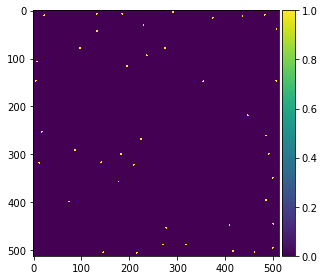

In [7]:
total_objs = []
total_coords = []
final_objs = []
for i in range(0,len(smoothed_imgs),2):
    img = smoothed_imgs[i].astype('uint8')
    
    th2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
                                cv2.THRESH_BINARY,81,2)
    
    mask = filters.median(th2)
    lab = skmeas.label(mask)
    objs = skmeas.regionprops(lab)
    for obj in objs:
        if obj.area < 1500 and obj.area > 250:
            total_objs.append(obj)
            total_coords.append(obj.centroid)

total_coords_array = np.array(total_coords)
tree = cKDTree(total_coords_array)
rows_to_fuse = list(tree.query_pairs(r=30.0))   # Change distance between objects here
keep = np.ones(total_coords_array.shape[0])
if(len(rows_to_fuse)):
    keep[np.array(rows_to_fuse)[:,0]] = 0
total_coords = total_coords_array[keep.astype(bool)] 

for obj in total_objs:
    if obj.centroid in total_coords:
        final_objs.append(obj)

canvas = np.zeros_like(img)
for coord in total_coords:
    rr, cc = disk((coord[0],coord[1]), 2)
    canvas[rr,cc] = 1
    

io.imshow(canvas)

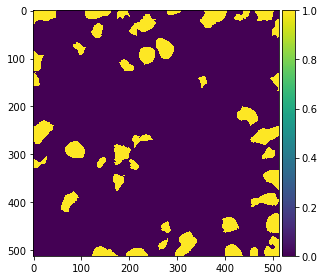

In [8]:
canvas_two = np.zeros_like(img)
for obj in final_objs:
    for coord in obj.coords:
        canvas_two[coord[0]][coord[1]] = 1
io.imshow(canvas_two)

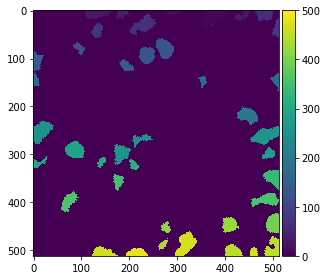

In [9]:
%matplotlib inline
#Applying watershed transform to split touch objects
dist = ndi.distance_transform_edt(canvas_two)
coords = peak_local_max(-dist, min_distance = 5, footprint=np.ones((5,5)),labels=canvas_two)
watershed_mask = np.zeros(dist.shape, dtype=bool)
watershed_mask[tuple(coords.T)] = True
markers, _ = ndi.label(watershed_mask)
labels = skseg.watershed(-dist,markers,mask=canvas_two,watershed_line=True)
io.imshow(labels)

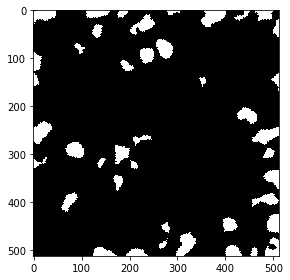

In [10]:
%matplotlib inline
#Closing edges
eroded_water = skmorph.binary_erosion(labels)
closed_one = skmorph.binary_closing(eroded_water)
closed_two = skmorph.binary_closing(closed_one)
io.imshow(closed_two)

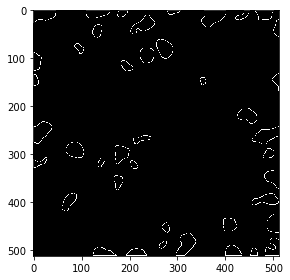

In [11]:
%matplotlib inline
#Canny edge detection
edges = feature.canny(closed_two, sigma = 3)

# Creating Border rectangle to create outer edge of cut off ROIs
border_len = 0
fill_mode = False


# Top border sealing
for i in range(0,edges.shape[1]-1):
    if edges[1][i] == True and edges[1][i+1] == False and fill_mode == False:
        fill_mode = True
    elif edges[1][i] == True and edges[1][i+1] == False and fill_mode == True:
        fill_mode = False
    if fill_mode == True:
        edges[1][i] = True
fill_mode = False # Fill mode is reset in between each axis sealing
# Right border sealing                
for i in range(0,edges.shape[0]-1):
    if edges[i][edges.shape[1]-2] == True and edges[i+1][edges.shape[1]-2] == False and fill_mode == False:
        fill_mode = True
    elif edges[i][edges.shape[1]-2] == True and edges[i+1][edges.shape[1]-2] == False and fill_mode == True:
        fill_mode = False
    if fill_mode == True:
        edges[i][edges.shape[1]-1] = True
fill_mode = False
## Bottom border sealing
for i in range(0,edges.shape[1]-1):
    if edges[edges.shape[0] - 2][i] == True and edges[edges.shape[0] - 2][i+1] == False and fill_mode == False:
        fill_mode = True
    elif edges[edges.shape[0] - 2][i] == True and edges[edges.shape[0] - 2][i+1] == False and fill_mode == True:
        fill_mode = False
    if fill_mode == True:
        edges[edges.shape[0] - 2][i] = True
fill_mode = False
# Left border sealing
for i in range(0,edges.shape[0]-1):
    if edges[i][1] == True and edges[i+1][1] == False and fill_mode == False:
        fill_mode = True
    elif edges[i][1] == True and edges[i+1][1] == False and fill_mode == True:
        fill_mode = False
    if fill_mode == True:
        edges[i][1] = True

io.imshow(edges)

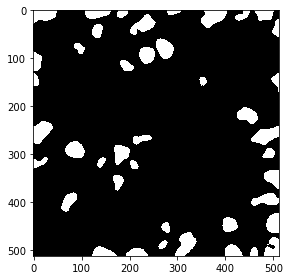

In [12]:
%matplotlib inline
#Filling in borders
dilated_edges = skmorph.binary_dilation(edges)
filled = ndi.binary_fill_holes(dilated_edges)
io.imshow(filled)

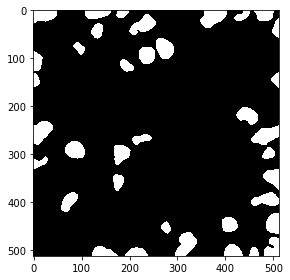

In [13]:
#Final separation erosion
eros_1= skmorph.binary_erosion(filled)
eros_2 = skmorph.binary_erosion(eros_1)
eros_3 = skmorph.binary_erosion(eros_2)
pre_final = skmorph.remove_small_objects(eros_3, min_size = 150)
dil_1 = skmorph.binary_dilation(pre_final)
dil_2 = skmorph.binary_dilation(dil_1)
dil_3 = skmorph.binary_dilation(dil_2)
final = skmorph.binary_dilation(dil_3)

io.imshow(final)

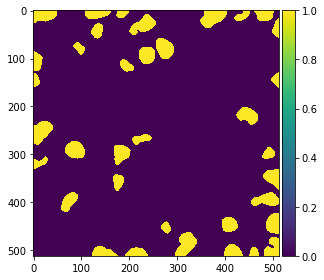

In [14]:
mask_label = skmeas.label(final)
objs = skmeas.regionprops(mask_label)
final = np.zeros_like(mask_label)

#Removing large objects
for obj in objs:
    if obj.area < 1500:
        final = final + (mask_label == obj.label)
io.imshow(final)

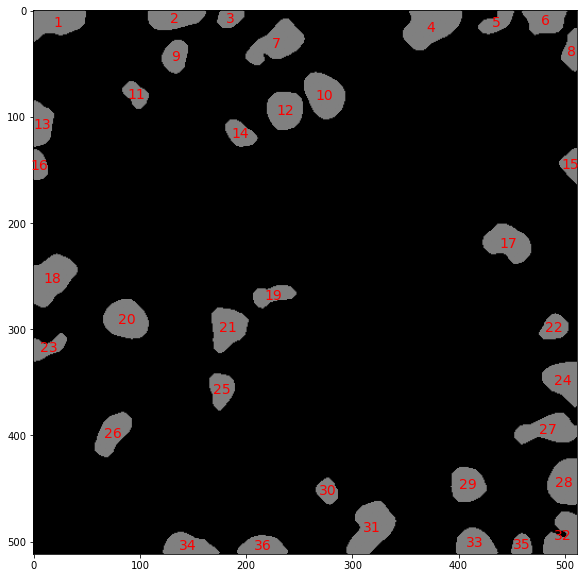

apical ROI labels:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36]
apical ROI pixel counts:  [1087  840  349 1494  454  763 1330  412  592 1268  404 1015  666  520
  348  328 1159 1409  558 1231 1067  492  475  953  611  907 1156 1016
  881  370 1482  936  752  770  312  643]


In [15]:
#Label and ID ROIS *From John's Notebook*
R, n = skmeas.label(final, return_num=True)
io.imsave(resultsdir + "/" + image_tags[roi_idx][0] + "-roi_mask_labelled.tif", np.int16(R), check_contrast=False) # Save labeled ROI Mask for movie
ROI, COUNT = np.unique(R, return_counts=True)
#Plot labels of ROIS on image *From John's Notebook*
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = [10, 10])
ax.imshow(final, norm=None, vmax=2, cmap='gray') # dim the white a bit, easier to see the annnotations
for props in skmeas.regionprops(R):
  y, x = props.centroid # get the centroid for each region
  t = ax.text(x, y, str(props.label), ha='center', va='center', size=14, c='r')
plt.show()
print("apical ROI labels: ", ROI[1:])
print("apical ROI pixel counts: ", COUNT[1:])

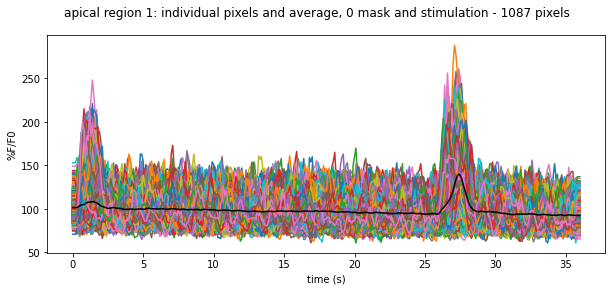

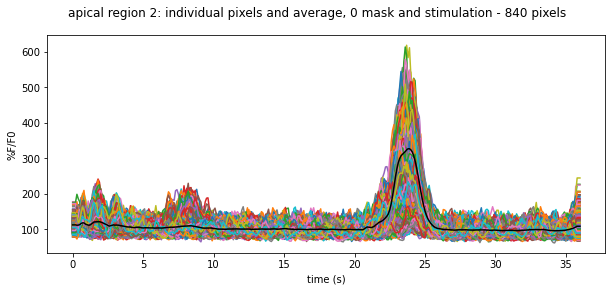

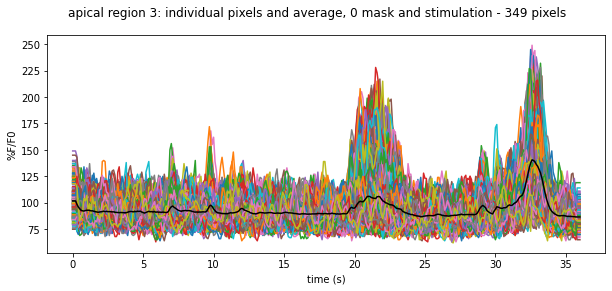

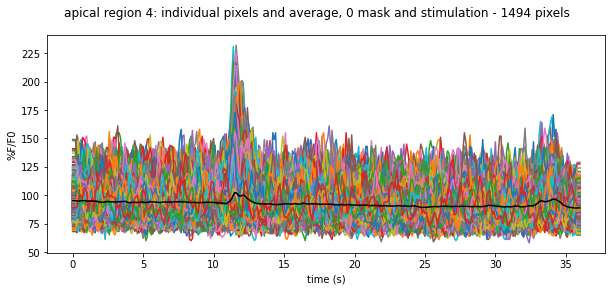

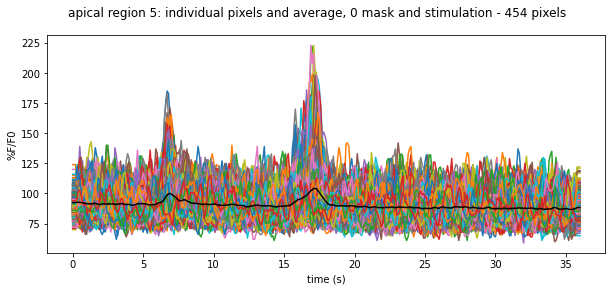

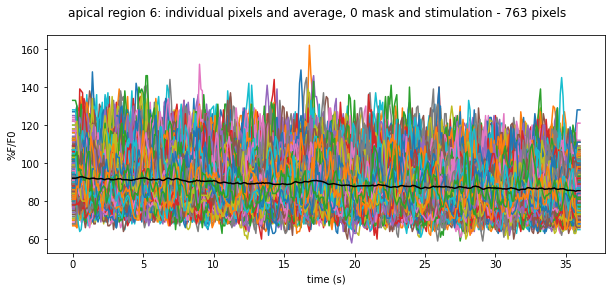

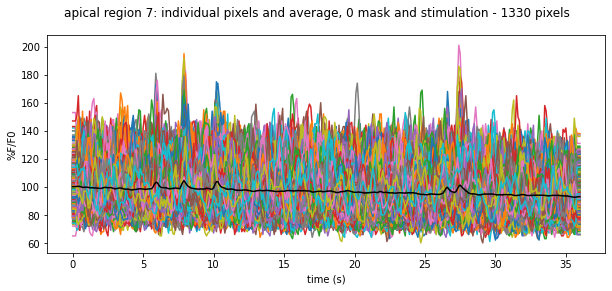

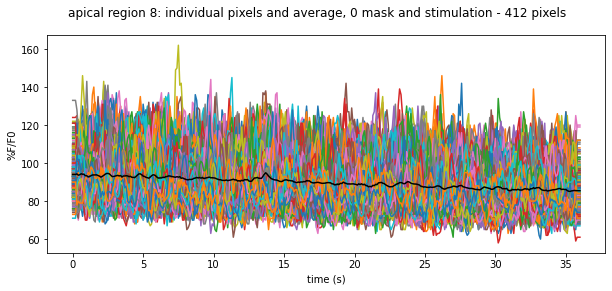

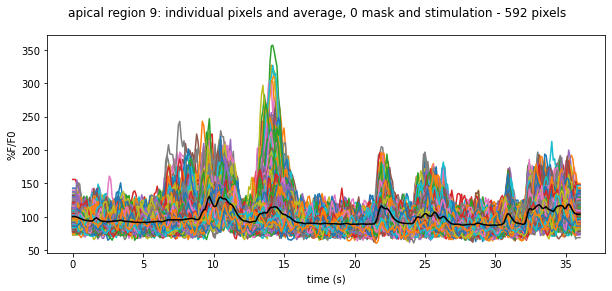

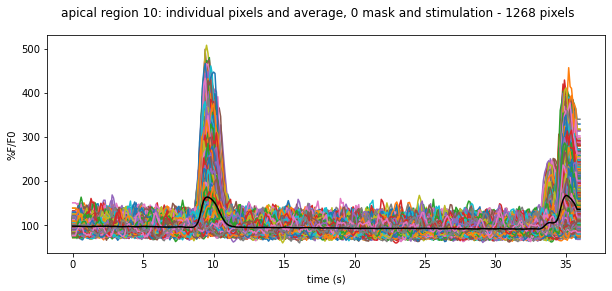

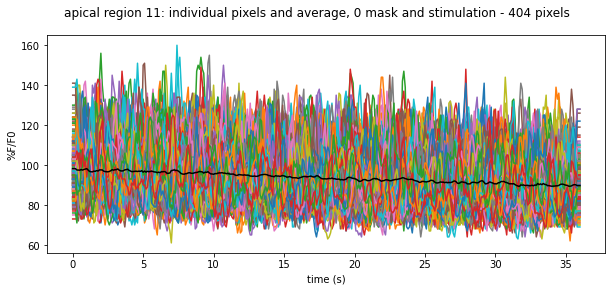

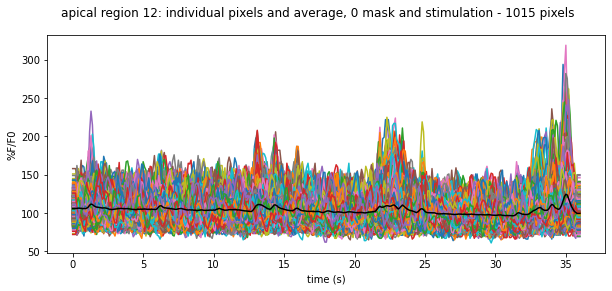

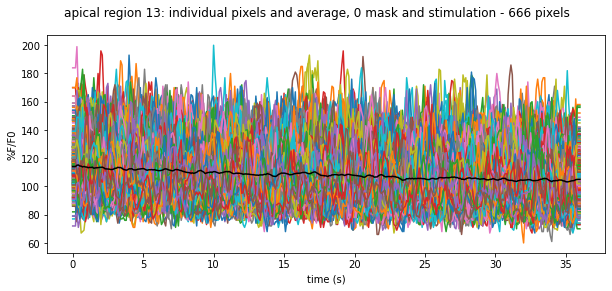

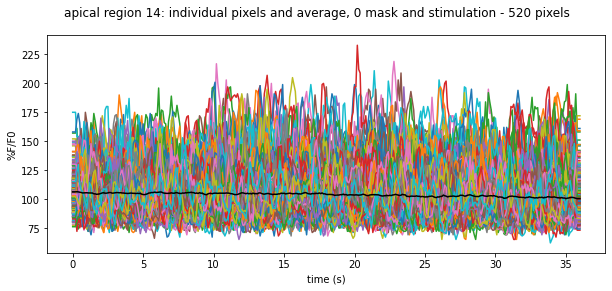

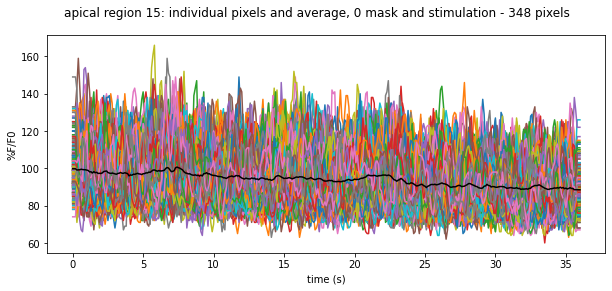

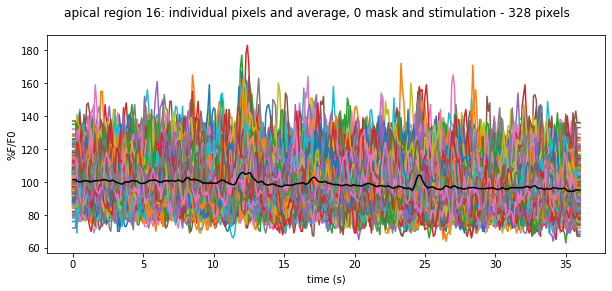

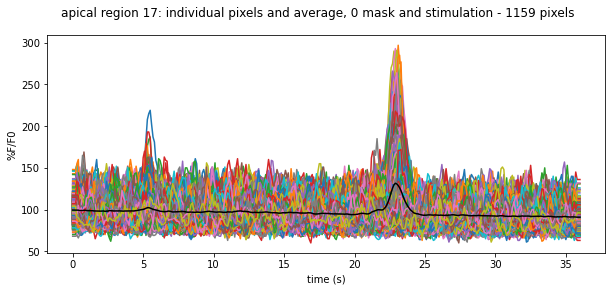

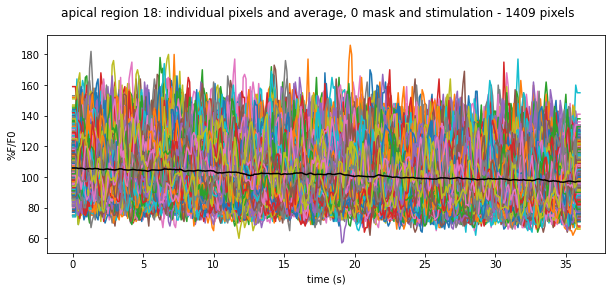

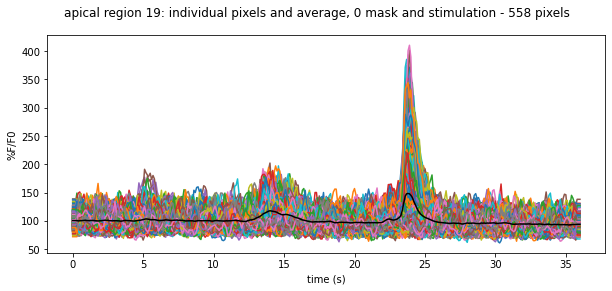

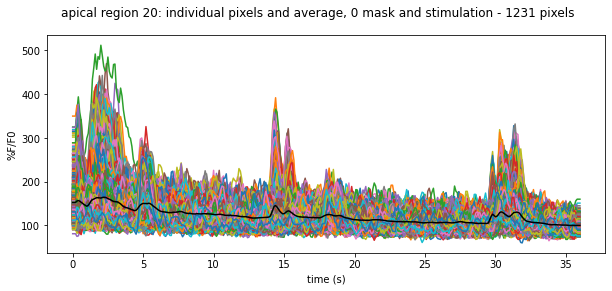

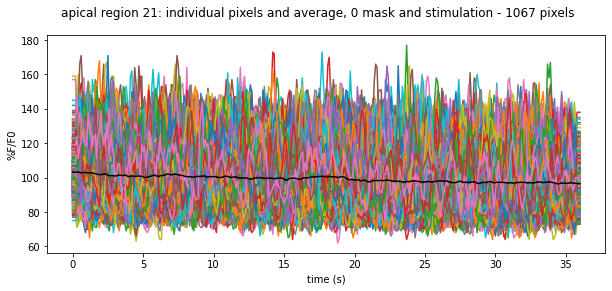

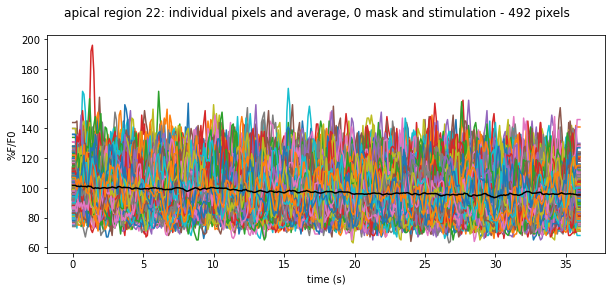

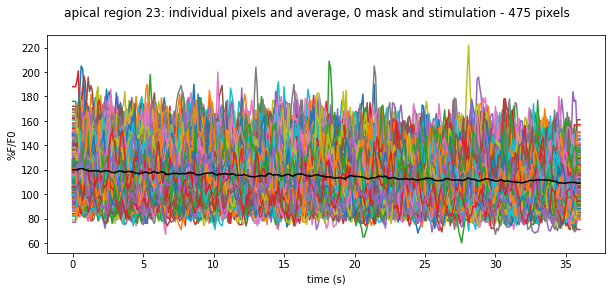

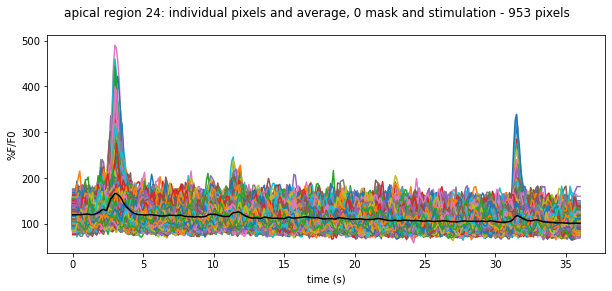

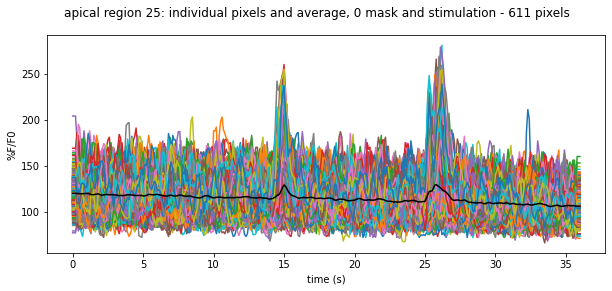

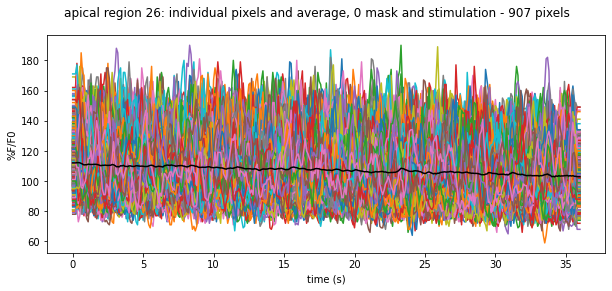

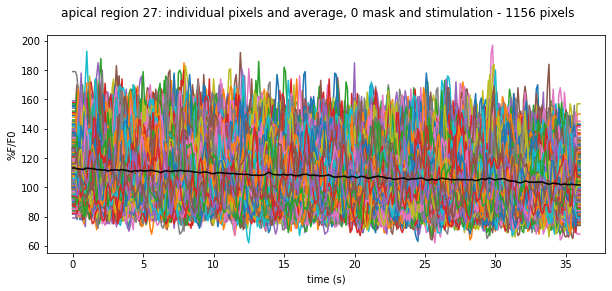

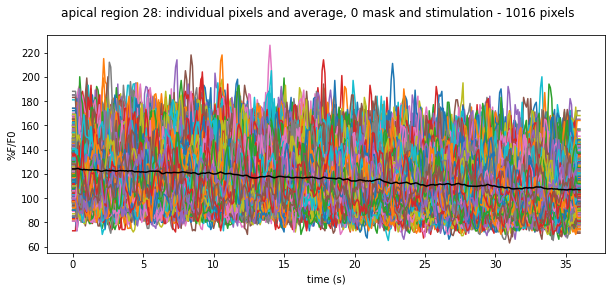

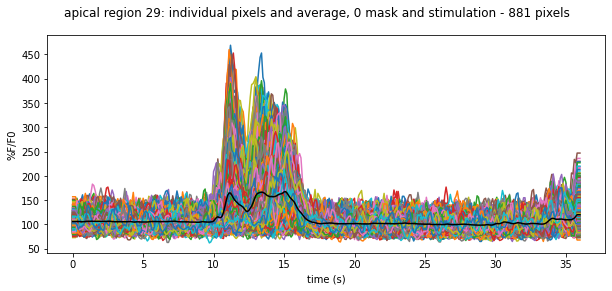

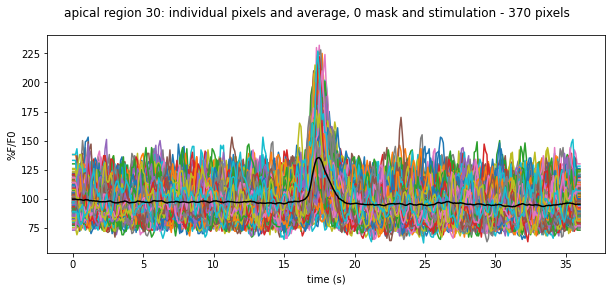

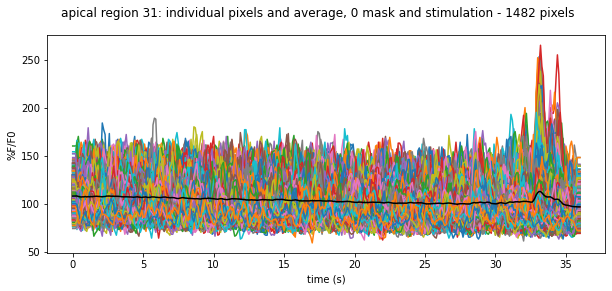

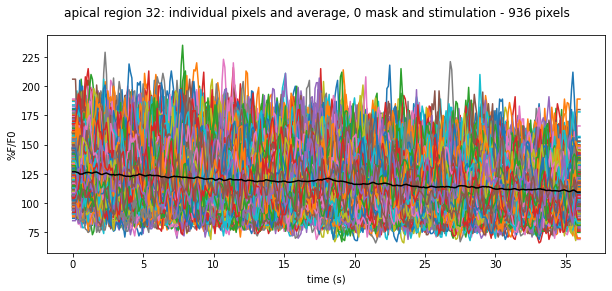

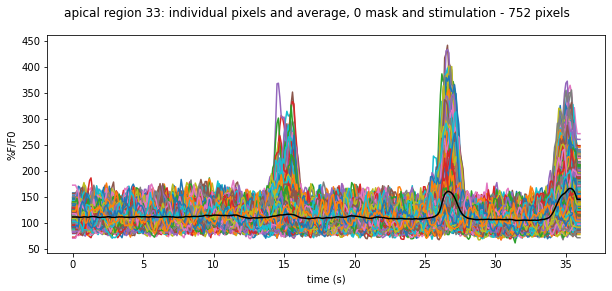

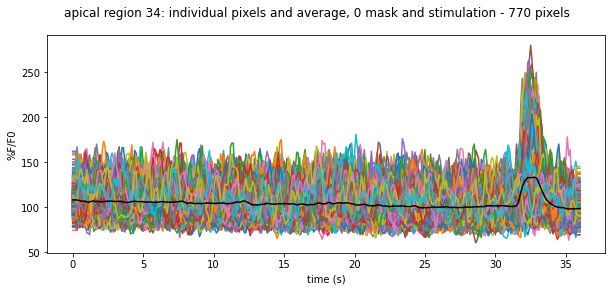

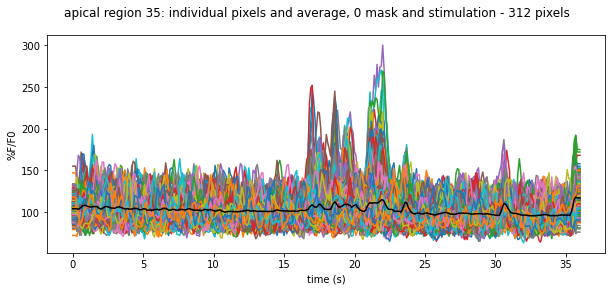

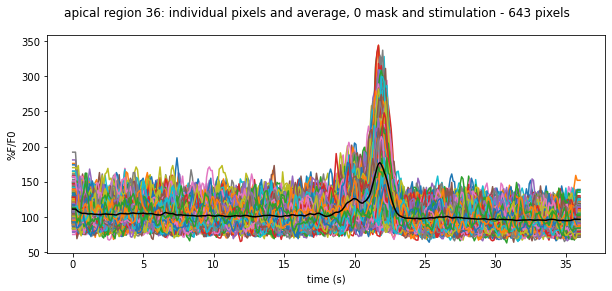

In [16]:
#Plotting region responses *From John's Notebook*
%matplotlib inline

# apical region plots using the mask
X = np.array(range(B0.shape[0])) * (1/image_fps) # the timebase

# create and save plots
for c in ROI:
  if(c==0):
    continue
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize = [10, 4])
  fig.suptitle('apical region ' + str(c)+ ": individual pixels and average, " + image_tags[meas_idx][0] + " mask and stimulation - " +str(COUNT[c]) + " pixels")
  S = B0[:, R==ROI[c]]
  T = np.sum(S, axis=1) / S.shape[1]
  ax.plot(X, S)
  ax.plot(X, T, color='black')
  ax.set(ylabel="%F/F0")
  ax.set(xlabel="time (s)")

  # save figure to pdf
  s = "/apical_region_" + str(c).zfill(2) + "-mask" + image_tags[meas_idx][0] + "-stim" + image_tags[meas_idx][0] + ".pdf"
  fig.savefig(resultsdir + s)
  
  plt.show()
  plt.close() # frees up memory


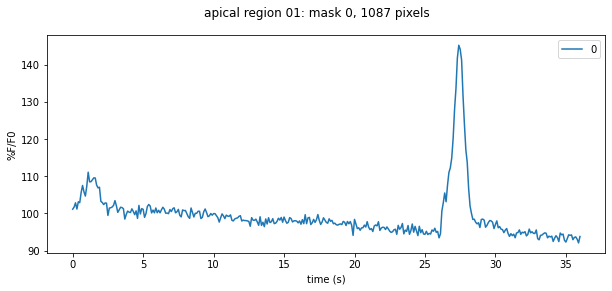

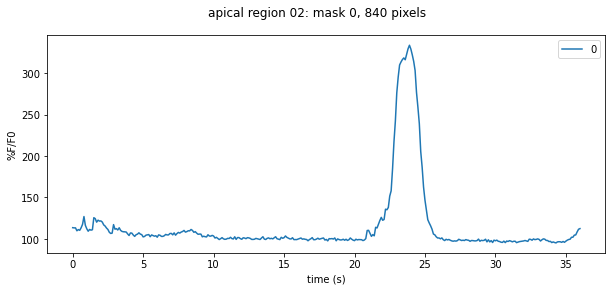

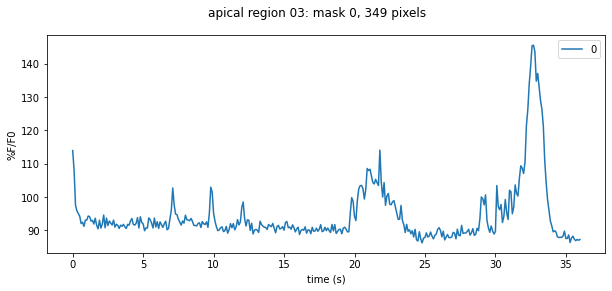

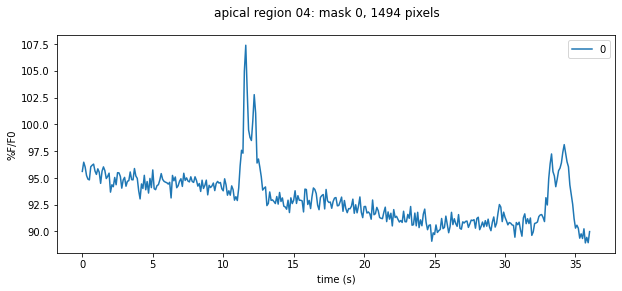

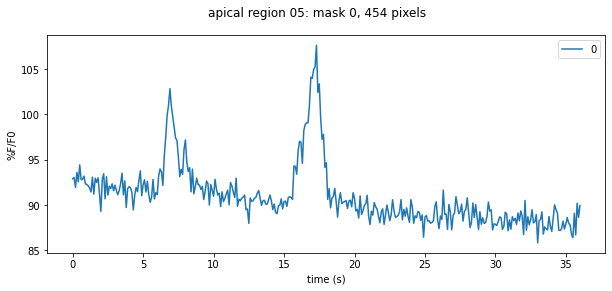

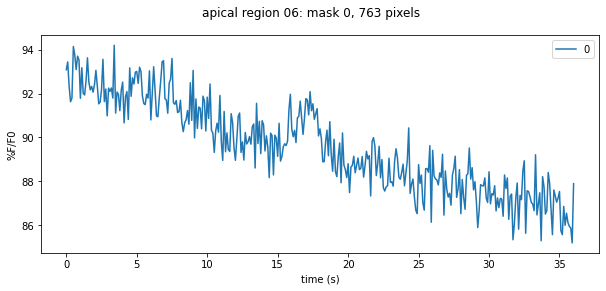

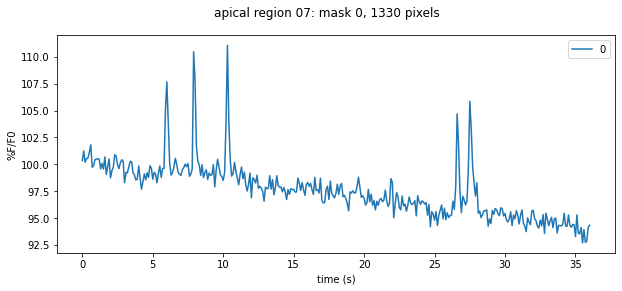

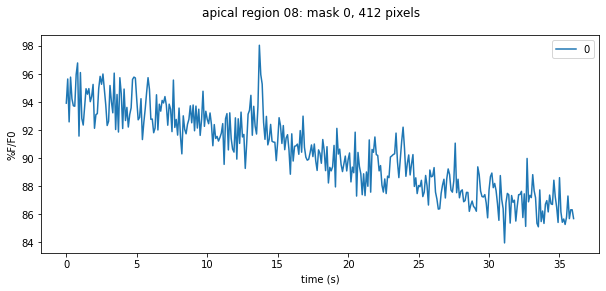

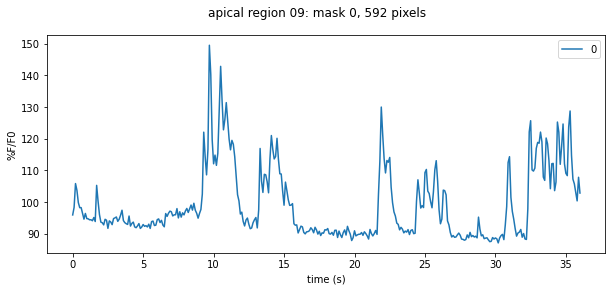

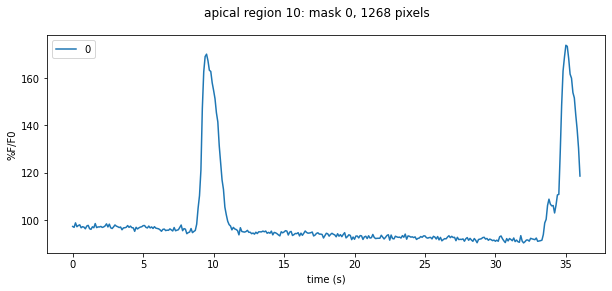

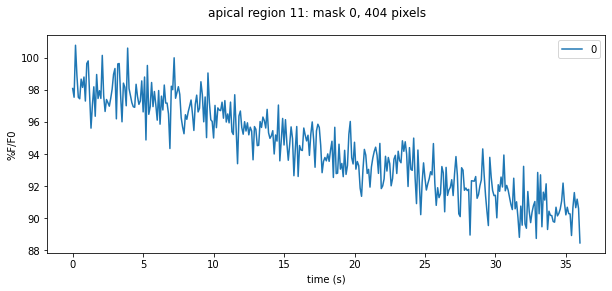

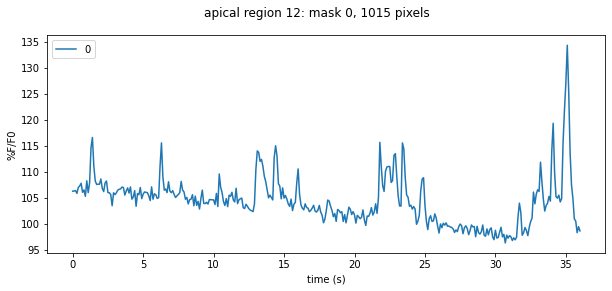

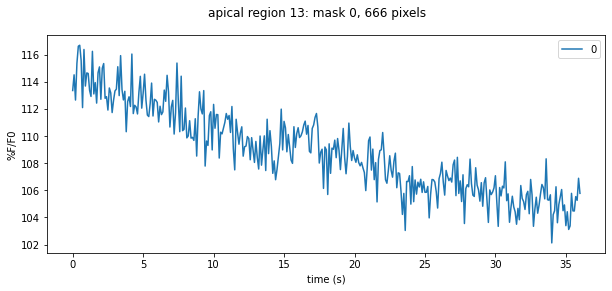

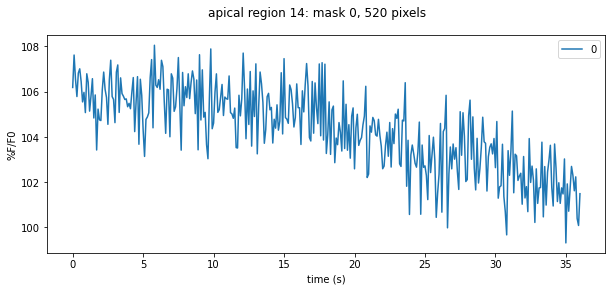

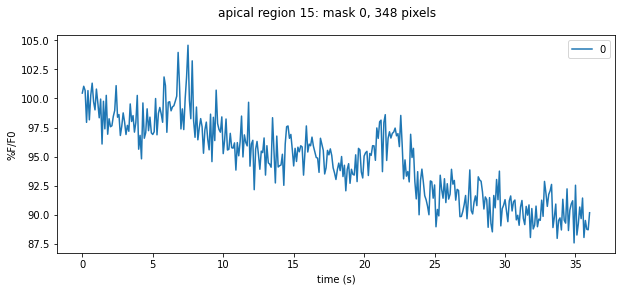

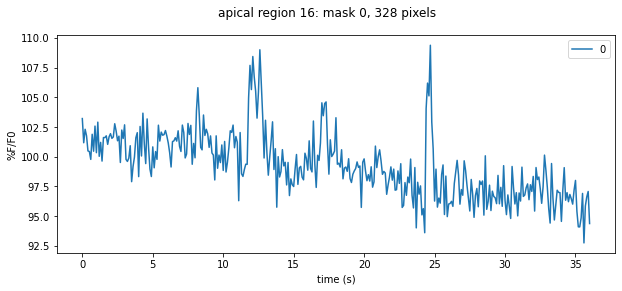

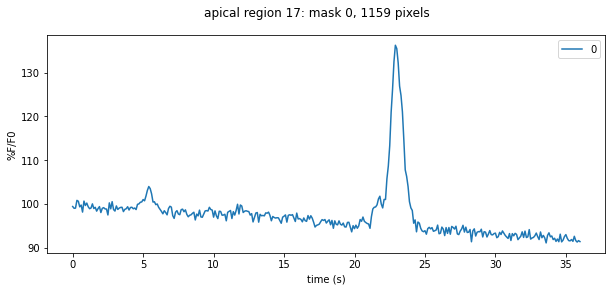

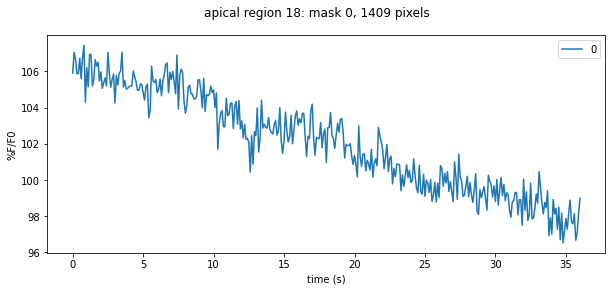

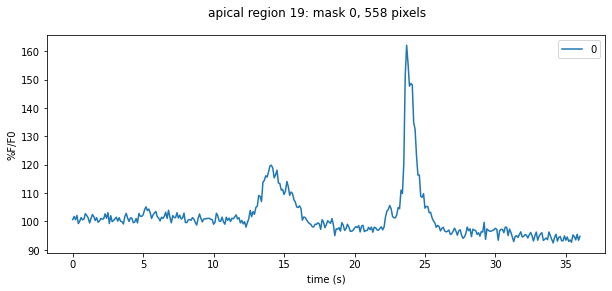

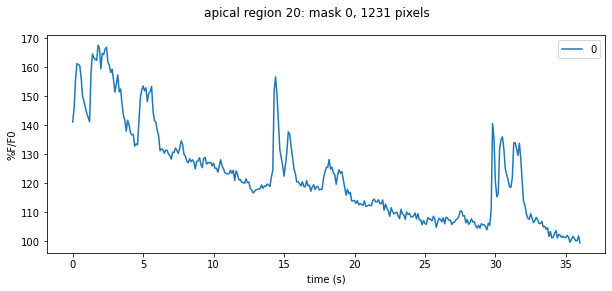

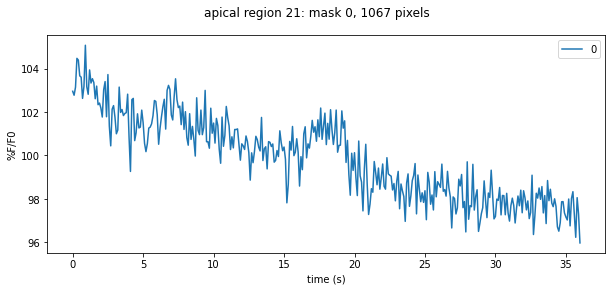

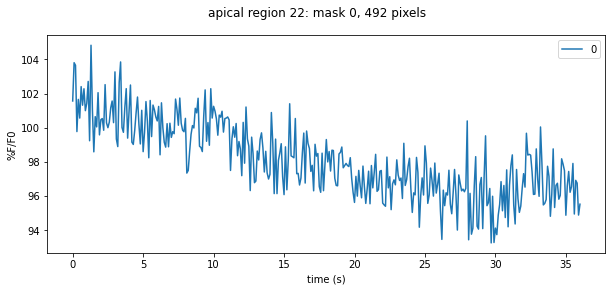

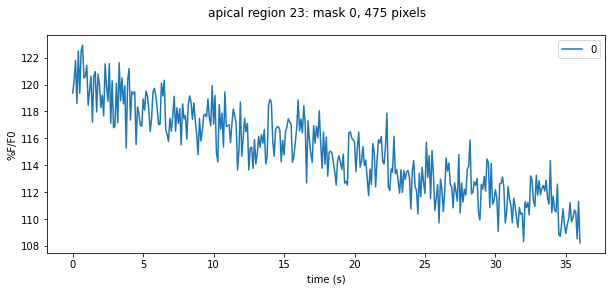

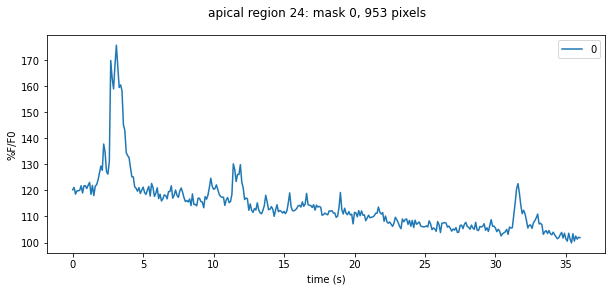

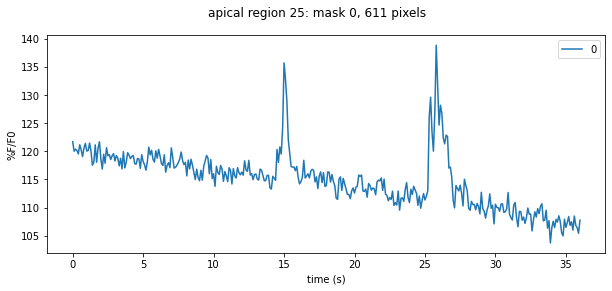

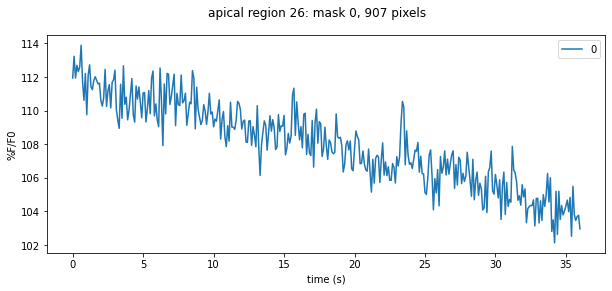

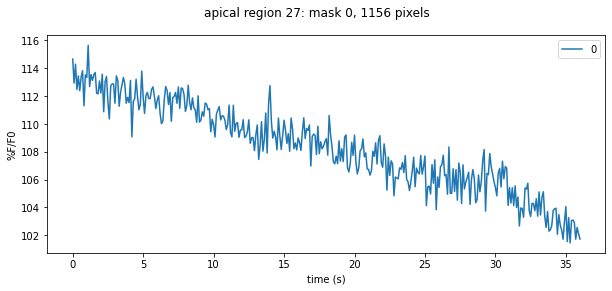

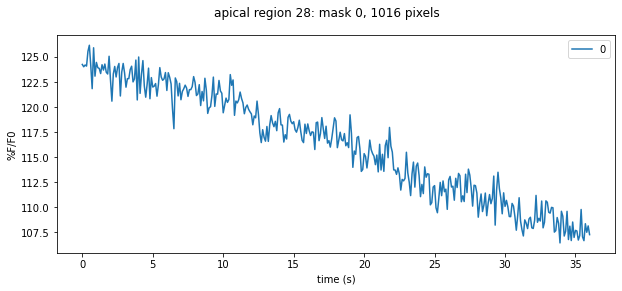

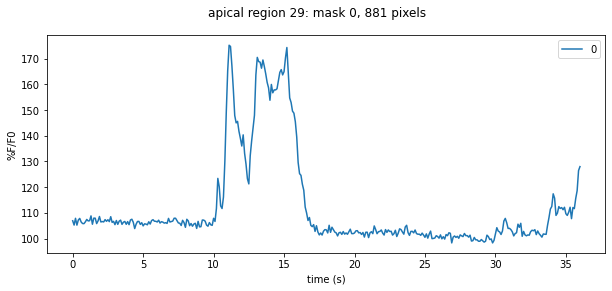

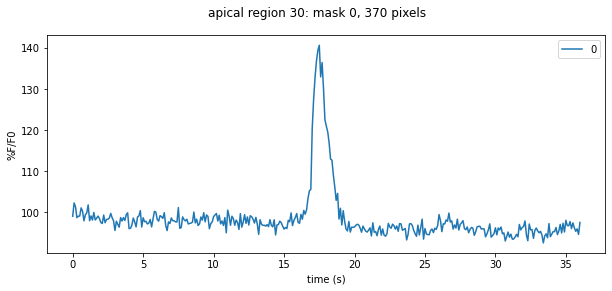

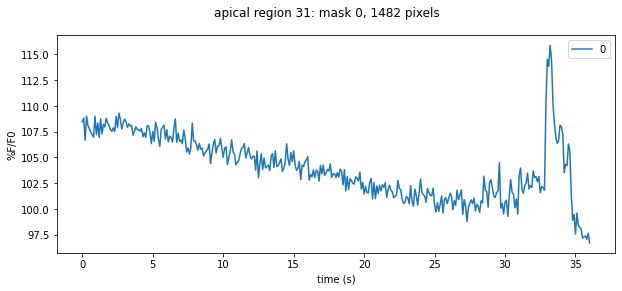

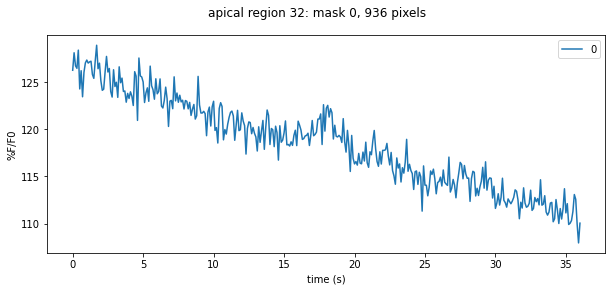

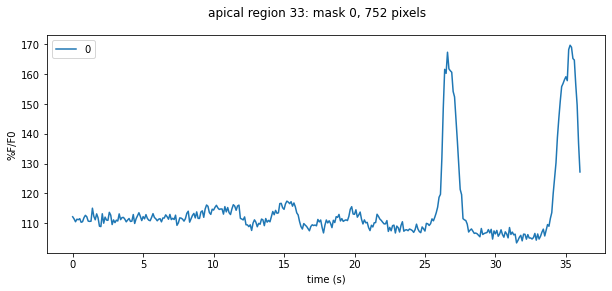

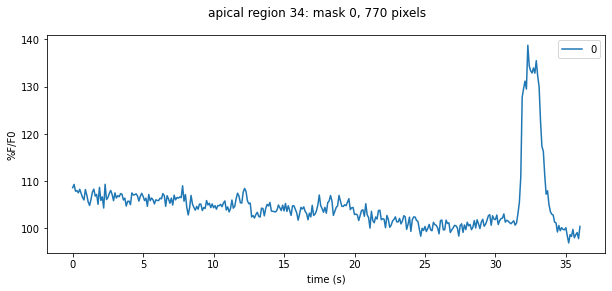

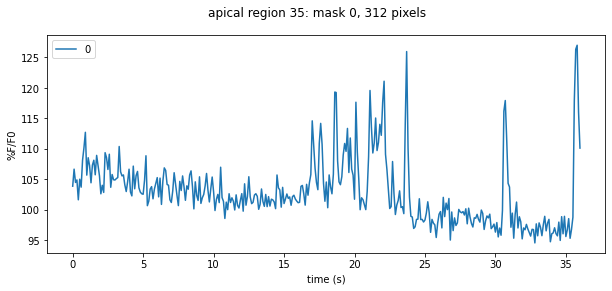

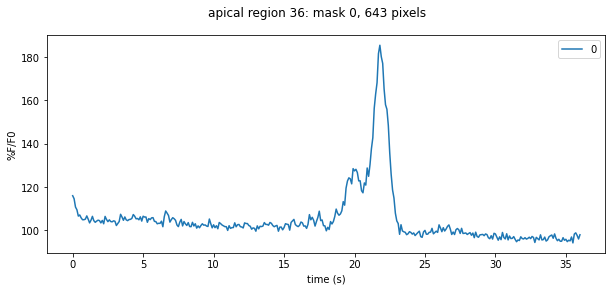

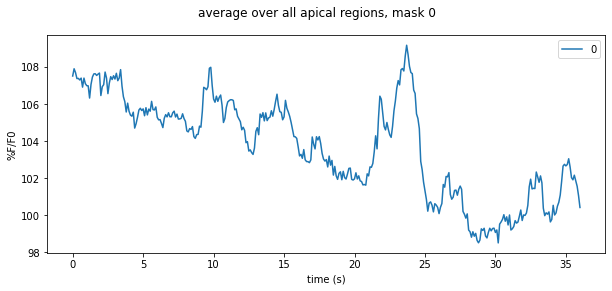

In [17]:
#Saving average graphs *From John's Notebook*
%matplotlib inline

# calculate, plot and save region responses for all stimulation frequencies

# calculate all of the results
RESULTS = np.zeros((1, ROI.shape[0]-1, B0.shape[0])) # array for all of the apical results
X = np.array(range(RESULTS.shape[2])) * (1/image_fps) # the timebase
f = image_files[meas_idx]
A0x = io.imread("../image_stacks/" + f)
for c in ROI:
    if(c==0):
        continue 
    S = A0x[:, R==ROI[c]]
    T = np.sum(S, axis=1) / S.shape[1]
    RESULTS[0, c-1] = T # save in the results array
# plot and save responses for all the stimulation frequencies by region
for n in range(1,len(ROI)):
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize = [10, 4])
  fig.suptitle('apical region ' + str(ROI[n]).zfill(2) + ": mask "+ image_tags[meas_idx][0] + ", " + str(COUNT[n]) + " pixels")

  ax.plot(X, np.transpose(RESULTS[:, n-1, :]))
  ax.set(ylabel="%F/F0")
  ax.set(xlabel="time (s)")
  ax.legend(image_tags[meas_idx])

  # save figure to pdf
  fig.savefig(resultsdir + "/apical_region_" + str(n).zfill(2) + "-mask" + image_tags[meas_idx][0] + "-stimALL.pdf")
    
  plt.show()
  plt.close() # frees up memory
  
  # save responses to CSV file
  with open (resultsdir + "/apical_region_" + str(n).zfill(2) + "-mask" + image_tags[meas_idx][0] + "-stimALL.csv", 'w') as file:
    writer = csv.writer(file)
    for i in range(RESULTS.shape[2]):
      t = np.append(X[i], RESULTS[:,n-1,i])
      writer.writerow('{:3.3e}'.format(x) for x in t)

# plot average of region responses for all the stimulation frequencies
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = [10, 4])
fig.suptitle("average over all apical regions, mask "+ image_tags[meas_idx][0])

Y = np.transpose(np.sum(RESULTS, axis=(1)))/RESULTS.shape[1]
ax.plot(X, Y)
ax.set(ylabel="%F/F0")
ax.set(xlabel="time (s)")
ax.legend(image_tags[meas_idx])

# save figure to pdf
fig.savefig(resultsdir + "/apical_region_AVG-mask" + image_tags[meas_idx][0] + "-stimALL.pdf")
    
plt.show()
plt.close() # frees up memory

# save average of responses to CSV file
with open (resultsdir + "/apical_region_AVG-mask" + image_tags[meas_idx][0] + "-stimALL.csv", 'w') as file:
  writer = csv.writer(file)
  for i in range(X.shape[0]):
    t = np.append(X[i], Y[i])
    writer.writerow('{:3.3e}'.format(x) for x in t)
